<a href="https://colab.research.google.com/github/victory256/Sample-ML-Repo/blob/hw10/%D0%AF%D0%BA%D1%83%D0%B1%D0%BE%D0%B2%D0%B0_hw10_trees_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX' -O data.csv

--2022-05-10 01:30:23--  https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX
Resolving docs.google.com (docs.google.com)... 142.251.6.138, 142.251.6.113, 142.251.6.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.6.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ihokpnamrc8g9ma4irs8vm3butmto2p/1652146200000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download [following]
--2022-05-10 01:30:25--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ihokpnamrc8g9ma4irs8vm3butmto2p/1652146200000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleus

В этой домашней работе вы будете предсказывать стоимость домов по их характеристикам.

Метрика качества: `RMSE`

Оценивание:
* Baseline - 2 балла
* Feature Engineering - 2 балла
* Model Selection - 3 балла
* Ensemble v.1 - 3 балла
* (*) Ensemble v.2 - дополнительно, 2 балла

### Описание датасета

Короткое описание данных:
```
price: sale price (this is the target variable)
id: transaction id
timestamp: date of transaction
full_sq: total area in square meters, including loggias, balconies and other non-residential areas
life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
floor: for apartments, floor of the building
max_floor: number of floors in the building
material: wall material
build_year: year built
num_room: number of living rooms
kitch_sq: kitchen area
state: apartment condition
product_type: owner-occupier purchase or investment
sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

full_all: subarea population
male_f, female_f: subarea population by gender
young_*: population younger than working age
work_*: working-age population
ekder_*: retirement-age population
n_m_{all|male|female}: population between n and m years old
build_count_*: buildings in the subarea by construction type or year
x_count_500: the number of x within 500m of the property
x_part_500: the share of x within 500m of the property
_sqm_: square meters
cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
trc_: shopping malls
prom_: industrial zones
green_: green zones
metro_: subway
_avto_: distances by car
mkad_: Moscow Circle Auto Road
ttk_: Third Transport Ring
sadovoe_: Garden Ring
bulvar_ring_: Boulevard Ring
kremlin_: City center
zd_vokzaly_: Train station
oil_chemistry_: Dirty industry
ts_: Power plant
```

### Setup

In [ ]:
!pip3 install catboost

     |████████████████████████████████| 76.6 MB 80 kB/s 


In [114]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import copy
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.experimental import enable_halving_search_cv # для HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from catboost import CatBoostRegressor
from sklearn import linear_model
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv("data.csv", parse_dates=["timestamp"])
df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,36,7,2,15,33,1,12,75,10,15318960
1,1,2012-10-04,64,64.0,16.0,NaN,NaN,NaN,NaN,NaN,...,2,2,0,0,13,1,0,6,1,6080000
2,2,2014-02-05,83,44.0,9.0,17.0,1.0,1985.0,3.0,10.0,...,13,6,1,8,18,0,1,52,0,17000000
3,3,2012-07-26,71,49.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,3,0,2,8,2,990000
4,4,2014-10-29,60,42.0,9.0,9.0,1.0,1970.0,3.0,6.0,...,3,1,0,5,8,0,1,34,5,7900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,2014-09-22,45,27.0,2.0,9.0,1.0,1978.0,2.0,5.0,...,9,0,0,6,29,0,1,46,10,7200000
19996,19996,2013-12-06,38,NaN,4.0,17.0,1.0,NaN,2.0,1.0,...,2,2,0,1,12,1,0,8,0,3971520
19997,19997,2014-06-26,35,14.0,9.0,22.0,1.0,2001.0,1.0,10.0,...,13,3,0,6,27,1,10,57,13,7200000
19998,19998,2014-01-21,51,30.0,8.0,17.0,1.0,2011.0,2.0,9.0,...,1,0,0,0,7,0,0,3,0,3300000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 292 entries, id to price
dtypes: datetime64[ns](1), float64(119), int64(157), object(15)
memory usage: 44.6+ MB


In [ ]:
df.isna().sum()

id                       0
timestamp                0
full_sq                  0
life_sq               4103
floor                  113
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price                    0
Length: 292, dtype: int64

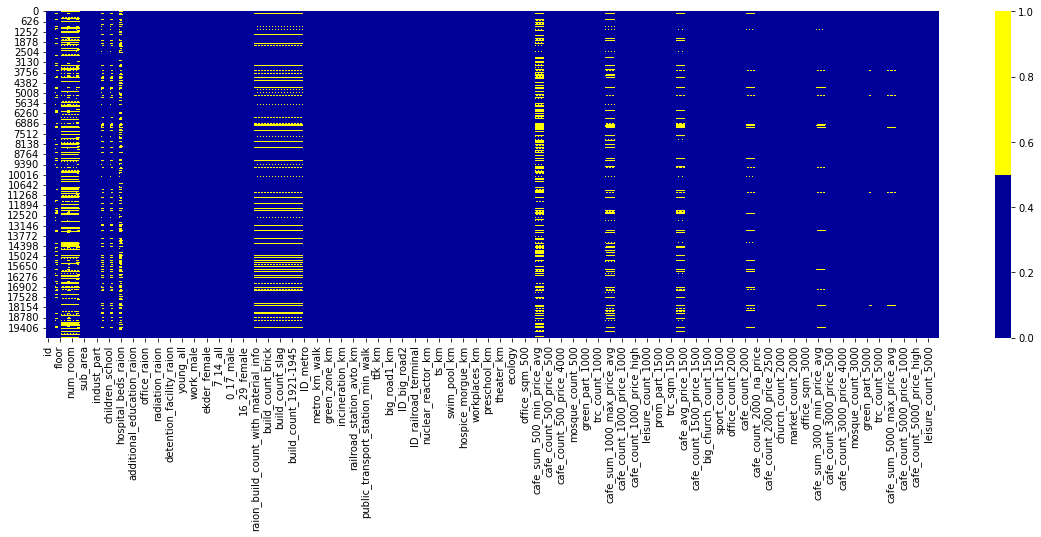

In [ ]:
cols = df.columns
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 

plt.figure(figsize = (20,6))
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
None

В dataset есть NaN значения - надо их обработать. 

15 признаков из 292  имеют тип object - надо посмотреть на сколько они нужны и при необходимости обработать.

In [ ]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
#numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
k = 0
for i in categorical_columns:
  k = k + 1
  print(k,') ',i,'\t',Counter(df[i]))

1 )  product_type 	 Counter({'Investment': 12840, 'OwnerOccupier': 7160})
2 )  sub_area 	 Counter({'Poselenie Sosenskoe': 1126, 'Nekrasovka': 1074, 'Poselenie Vnukovskoe': 859, 'Poselenie Moskovskij': 603, 'Poselenie Voskresenskoe': 464, 'Tverskoe': 449, 'Mitino': 436, 'Krjukovo': 343, "Mar'ino": 338, 'Poselenie Filimonkovskoe': 323, 'Poselenie Shherbinka': 288, 'Juzhnoe Butovo': 287, 'Zapadnoe Degunino': 276, 'Solncevo': 273, 'Otradnoe': 240, 'Poselenie Desjonovskoe': 226, 'Bogorodskoe': 224, 'Nagatinskij Zaton': 206, 'Strogino': 206, 'Izmajlovo': 205, "Gol'janovo": 204, 'Nagornoe': 202, "Tekstil'shhiki": 201, 'Ljublino': 189, 'Severnoe Tushino': 188, 'Chertanovo Juzhnoe': 179, 'Birjulevo Vostochnoe': 176, 'Horoshevo-Mnevniki': 176, 'Ochakovo-Matveevskoe': 176, 'Zjuzino': 175, 'Vyhino-Zhulebino': 164, 'Perovo': 162, 'Ramenki': 161, 'Bibirevo': 158, 'Kosino-Uhtomskoe': 158, 'Jasenevo': 157, "Kon'kovo": 150, "Kuz'minki": 147, 'Orehovo-Borisovo Juzhnoe': 146, 'Veshnjaki': 144, 'Golovinsk

Видим, что большинство категориальных признаков имеют значения yes/no, поэтому заменим их на 1/0. Значения признака product_type тоже заменим на 1/0. Пусть OwnerOccupier = 1, Investment = 0.

Признак ecology имеет значения от Плохо до Отлично, поэтому их тоже можно заменить числами. Пусть 'no data' = 1, 'poor' = 2, 'satisfactory' = 3, 'good' = 4, 'excellent' = 5.

Признак sub_area (name of the district) удалим, т.к. каждый район представлена в среднем 100 объявлениями (гистограмма ниже). Возможно районы объединяются в области, которые территориально хорошо выделяются, но их расположения в координатах нам не указано в dataset. Поэтому признак sub_area нам не поможет.

Количество разных значений sub_area (name of the district) =  146


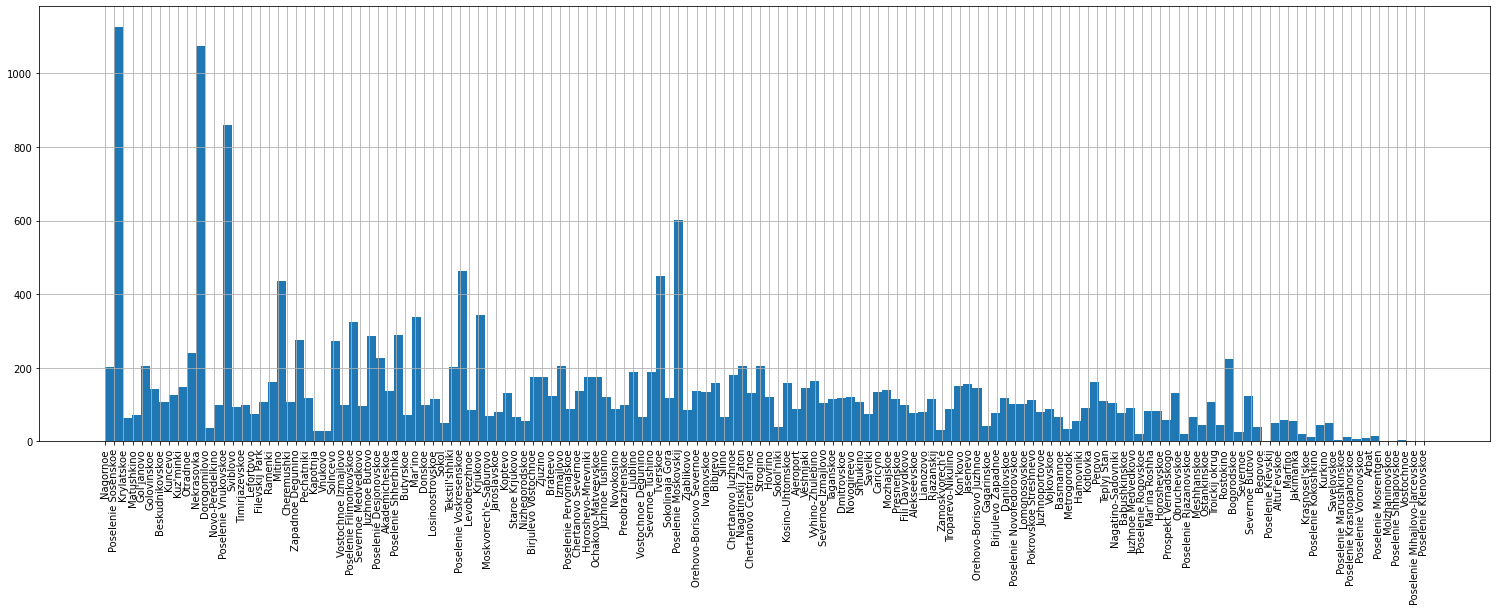

In [ ]:
print('Количество разных значений sub_area (name of the district) = ',len(df['sub_area'].unique()))
df['sub_area'].hist(xrot=90, bins=len(df['sub_area'].unique()), figsize=(26,8))
None

In [ ]:
def yes_no(column_yes_no):  # переводим yes/no в 1/0
  return 1 if column_yes_no =='yes' else 0
def product_type_str(product_type_str):  # переводим product_type в 1/0
  return 1 if product_type_str =='OwnerOccupier' else 0
def ecology_str(ecology_str):  # переводим ecology в оценки 1-5
  if ecology_str == 'excellent':
    ecology_num = 5
  elif ecology_str == 'good':
    ecology_num = 4
  elif ecology_str == 'satisfactory':
    ecology_num = 3
  elif ecology_str == 'poor':
    ecology_num = 2
  else:
    ecology_num = 2
  return ecology_num

In [ ]:
df_1 = df.copy(deep=True)

df_1['product_type']= df_1['product_type'].apply(product_type_str)   # заменили признак
df_1['ecology']= df_1['ecology'].apply(ecology_str)   # заменили признак

for i in categorical_columns:
  if i!='product_type' and i!='ecology' and i!='sub_area':
    df_1[i]= df_1[i].apply(yes_no)   # заменили признак

df_1 = df_1.drop(columns=['sub_area']) # убрать признак из рассмотрения перед обучением

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 291 entries, id to price
dtypes: datetime64[ns](1), float64(119), int64(171)
memory usage: 44.4 MB


Заменили категориальные признаки. Теперь признак timestamp разобьем на день, месяц, год. 

In [ ]:
df_1['day']=pd.to_datetime(df_1['timestamp']).dt.day        # день создания объявления = новый признак
df_1['dayofweek']=pd.to_datetime(df_1['timestamp']).dt.dayofweek        # день недели создания объявления = новый признак
df_1['month']=pd.to_datetime(df_1['timestamp']).dt.month    # месяц создания объявления = новый признак
df_1['year']=pd.to_datetime(df_1['timestamp']).dt.year      # год создания объявления = новый признак
#df_1 = df_1.drop(columns=['timestamp']) # убрать признак из рассмотрения перед обучением
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 295 entries, id to year
dtypes: datetime64[ns](1), float64(119), int64(175)
memory usage: 45.0 MB


Тогда остаются только числовые признаки. Теперь посмотрим на NaN значения.

признаки с NaN значениями = 51  столбцов из 295


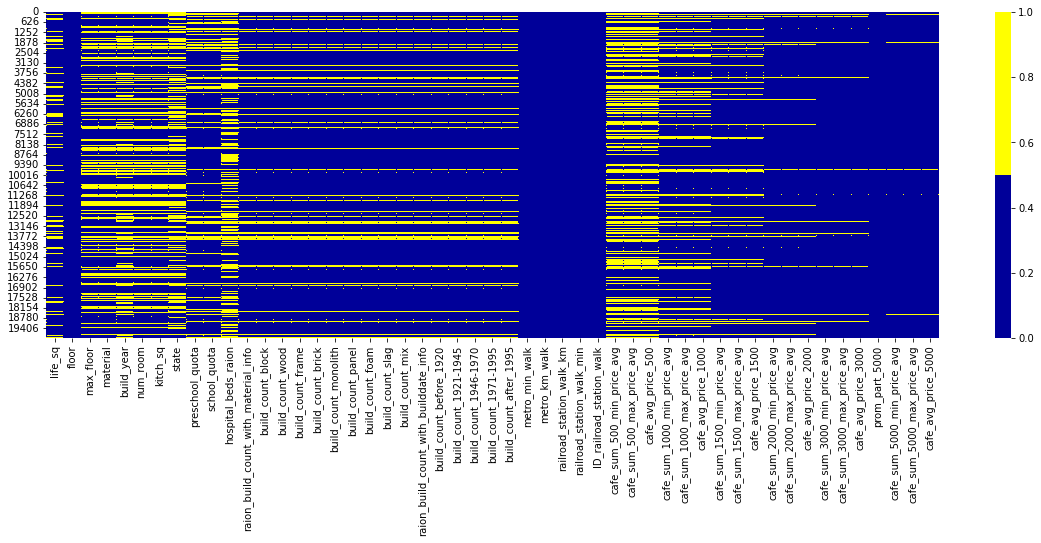

In [ ]:
cols = df_1.loc[:, df_1.isnull().any()].columns
print('признаки с NaN значениями =',len(cols), ' столбцов из',len(df_1.columns.to_list()))
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 

plt.figure(figsize = (20,6))
sns.heatmap(df_1[cols].isnull(), cmap=sns.color_palette(colours))
None

В dataset получается 51 признак из 292 с Nan значениями. Удалять их нельзя, потому что это 1/6 имеющихся признаков. Визуально в разных столбцах разное количество Nan. Посмотрим какой процент в каждом столбце занимают Nan-значения.

In [ ]:
nan_column = df_1[cols].isna().sum()/20_000*100
nan_column

life_sq                                  20.515
floor                                     0.565
max_floor                                31.515
material                                 31.515
build_year                               44.525
num_room                                 31.515
kitch_sq                                 31.515
state                                    44.535
preschool_quota                          21.395
school_quota                             21.385
hospital_beds_raion                      47.020
raion_build_count_with_material_info     15.875
build_count_block                        15.875
build_count_wood                         15.875
build_count_frame                        15.875
build_count_brick                        15.875
build_count_monolith                     15.875
build_count_panel                        15.875
build_count_foam                         15.875
build_count_slag                         15.875
build_count_mix                         

Удалим столбцы с более 40 % Nan-значений. Думаю, что такие признаки не информативны. А в остальных заменим Nan на медианное значение со столбцу.

In [ ]:
df_1 = df_1.drop(columns=nan_column[nan_column>40].index.to_list()) # 
nan_column[nan_column>40].index.to_list()

['build_year',
 'state',
 'hospital_beds_raion',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500']

Прежде чем заменять Nan в данных разделим на train и test.

Разделите имеющиеся у вас данные на обучающую и тестовую выборки. В качестве обучающей выборки возьмите первые 80% данных, последние 20% - тестовая выборка.

In [ ]:
df_2 = df_1.copy(deep=True)
y = df_2['price']
X = df_2.drop(columns=['price','timestamp'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

Теперь заменим Nan-значения в train и test частях.

In [ ]:
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())
print('для проверки: количество Nan-значений в X_train =',X_train.isna().sum().sum(),'в X_test =',X_test.isna().sum().sum())

для проверки: количество Nan-значений в X_train = 0 в X_test = 0


Возможно в ваших моделях вам придется указывать, какие колонки являются категориальными (например, в бустингах). Для упрощения предлагается разделить колонки по следующему принципу:
```
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))
```

### Baseline (2 балла)

В качестве Baseline обучите `DecisionTreeRegressor` из `sklearn`.

In [ ]:
clf = DecisionTreeRegressor(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

Проверьте качество на отложенной выборке.

R^2 = 0.5143019848499304


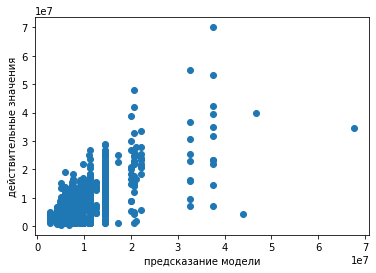

In [ ]:
y_pred = clf.predict(X_test)
plt.scatter(y_pred, y_test)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',clf.score(X_test, y_test))

R^2 показывает зависимость между переменными. Сейчас она = 0.51, можно использовать как Baseline, но хотелось бы поднять выше, ближе к 0,8. По графику тоже видно, что точки далеко от биссектрисы. Поэтому попробуем перебрать глубины деревьев, может для нашей задачи 5 это мало.

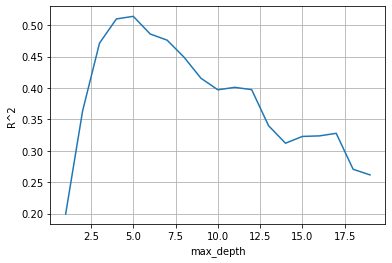

In [ ]:
R2 = []

ranges = range(1, 20)
for depth in ranges:
  clf = DecisionTreeRegressor(max_depth=depth, random_state=42)
  clf.fit(X_train, y_train)
  R2.append(clf.score(X_test, y_test))

plt.plot(list(ranges), R2)
plt.xlabel('max_depth')
plt.ylabel('R^2')
plt.grid()
plt.show()

По графику получается, что глубина = 5 оптимальная. Попробуем еще перебрать количество листьев.

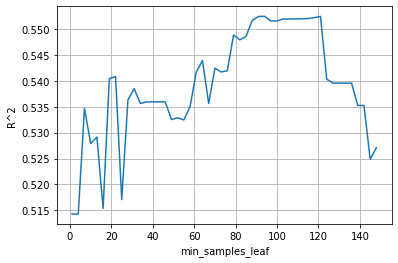

In [ ]:
R2 = []

ranges = range(1, 150, 3)
for min_samples_leaf in ranges:
  clf = DecisionTreeRegressor(max_depth=5, min_samples_leaf=min_samples_leaf, random_state=42)
  clf.fit(X_train, y_train)
  R2.append(clf.score(X_test, y_test))

plt.plot(list(ranges), R2)
plt.xlabel('min_samples_leaf')
plt.ylabel('R^2')
plt.grid()
plt.show()

Оставим дерево с max_depth=5 и min_samples_leaf=100 как Baseline с R^2 = 0.55. Хотя на кросс-плоте выглядят они пока плохо.

R^2 = 0.5515723239754639
MSE = 8929942367467.973


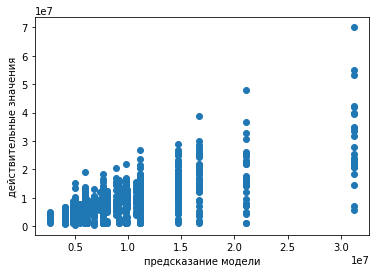

In [ ]:
clf = DecisionTreeRegressor(max_depth=5, min_samples_leaf=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plt.scatter(y_pred, y_test)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',clf.score(X_test, y_test))
print('MSE =',metrics.mean_squared_error(y_pred, y_test))

### Feature Engineering (2 балла)

Часто улучшить модель можно с помощью аккуратного Feature Engineering.

Добавим в модель дополнительные признаки:
* "Как часто в этот год и этот месяц появлялись объявления"
* "Как часто в этот год и эту неделю появлялись объявления"

In [ ]:
df_3 = df_1.copy(deep=True)
list_column_all = df_3.columns.tolist()

In [ ]:
month_year = (df_3.timestamp.dt.month + df_3.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_3["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df_3.timestamp.dt.isocalendar().week + df_3.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_3["week_year_cnt"] = week_year.map(week_year_cnt_map)

Добавьте следюущие дополнительные признаки:
* Месяц (из колонки `timestamp`)
* День недели (из колонки `timestamp`)
* Отношение "этаж / максимальный этаж в здании" (колонки `floor` и `max_floor`)
* Отношение "площадь кухни / площадь квартиры" (колонки `kitch_sq` и `full_sq`)

По желанию можно добавить и другие признаки.

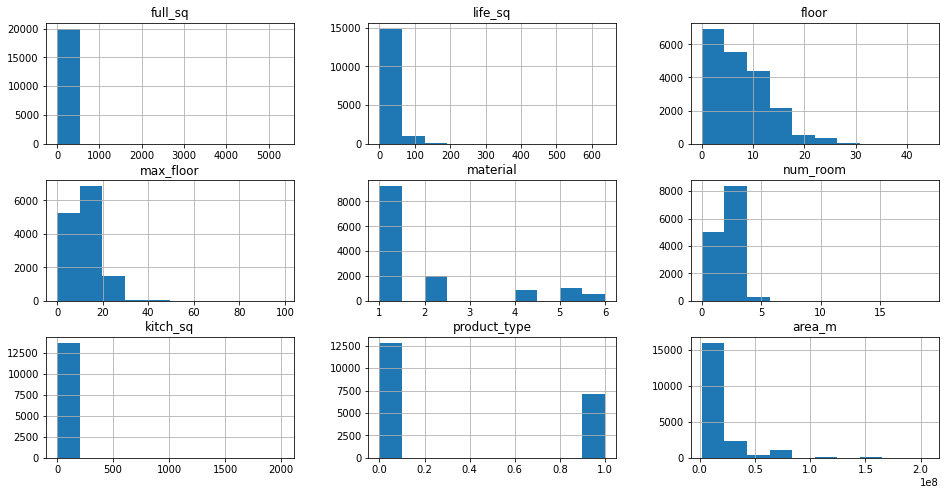

In [ ]:
df_3[list_column_all[2:11]].hist(figsize=(16,8))
None

Видим, что многие признаки не имеют форму нормального распределения. Поэтому прологарифмируем их посмотрим как изменится R^2.

In [ ]:
fig = px.pie(df_3, names='office_count_500', title='распределение значений')
#fig.show(renderer="colab")
None

In [ ]:
#df_3[list_column_all[281:]].hist(figsize=(16,8))
None

Признаки Месяц и День недели из колонки timestamp мы уже добавили. Добавим отношение этажей и площадей. Ограничим значения сверху 1.

In [ ]:
list_column_all = df_3.columns.tolist()
list_not_log_column = ['price', 'timestamp', 'raion_popul', 'preschool_education_centers_raion', \
                       'children_school', 'school_education_centers_raion', \
                       'young_male', 'young_female', 'work_all', 'work_male', \
                       'work_female', 'ekder_all', 'ekder_male', 'ekder_female', \
                       '0_6_all', 'ID_big_road1', 'ID_railroad_terminal', \
                       'ecology', 'day', 'dayofweek', 'month', 'year', \
                       'month_year_cnt', 'week_year_cnt']                        
del_column = ['culture_objects_top_25', 'culture_objects_top_25_raion', \
              'office_raion', 'thermal_power_plant_raion', 'oil_chemistry_raion', \
              'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', \
              'detention_facility_raion', 'water_1line', 'railroad_1line', \
              'cafe_count_500_price_4000', 'cafe_count_500_price_high', \
              'mosque_count_500', 'cafe_count_1000', 'cafe_count_1000_price_2500', \
              'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', \
              'mosque_count_1000', 'leisure_count_1000', 'mosque_count_1500', \
              'leisure_count_1500' ]
                                          
for i in list_column_all:
  if i not in list_not_log_column:
    df_3[i]=np.log(np.maximum(0.1,df_3[i]))

df_3['floor_max_floor'] = np.minimum(1, df_3['floor'] / df_3['max_floor'])
df_3['kitch_sq_full_sq'] = np.minimum(1, df_3['kitch_sq'] / df_3['full_sq'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Теперь гистограммы выглядят лучше.

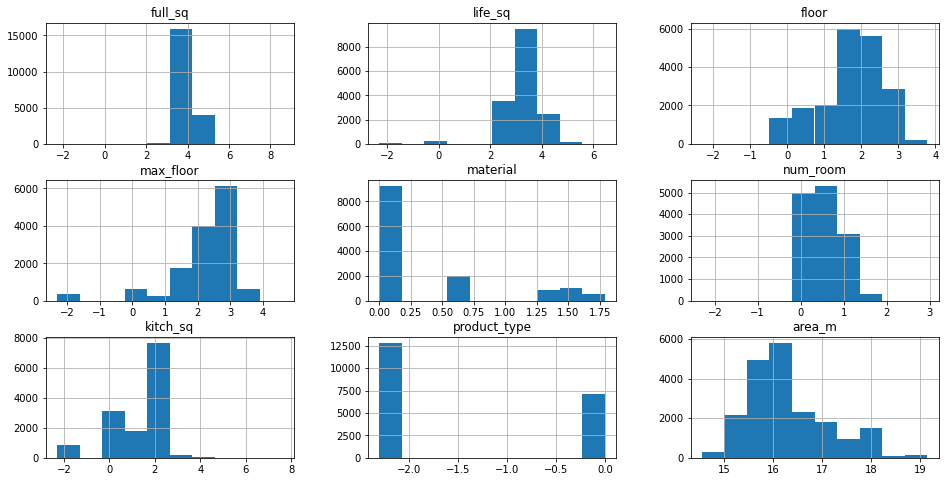

In [ ]:
df_3[list_column_all[2:11]].hist(figsize=(16,8))
None

Разделите выборку на обучающую и тестовую еще раз (потому что дополнительные признаки созданы для исходной выборки).

In [ ]:
df_4 = df_3.copy(deep=True)
y = df_4['price']
X = df_4.drop(columns=['price','timestamp'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

для проверки: количество Nan-значений в X_train = 0 в X_test = 0
R^2 = 0.5106400068744308
MSE = 9745064297317.7


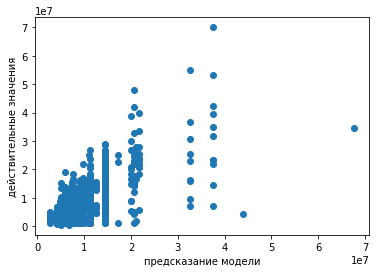

In [ ]:
X_train_1 = X_train.fillna(X_train.median())
X_test_1 = X_test.fillna(X_test.median())
print('для проверки: количество Nan-значений в X_train =',X_train_1.isna().sum().sum(),'в X_test =',X_test_1.isna().sum().sum())


clf = DecisionTreeRegressor(max_depth=5, random_state=42)
clf.fit(X_train_1, y_train)

y_pred = clf.predict(X_test_1)
plt.scatter(y_pred, y_test)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',clf.score(X_test_1, y_test))
print('MSE =',metrics.mean_squared_error(y_pred, y_test))

В результате логарифмирования R^2 упал с 0,55 до 0,51. Попробуем убрать часть признаков и посмотрим на результат.

Просматривая гистограммы признаков увидели, что некоторые имеют одно значения для 90% объявлений. Уберем такие через VarianceThreshold. Некоторые признакие выписывали в del_column, но могли что-то пропустить, поэтому будет точнее через VarianceThreshold.

In [ ]:
vth = VarianceThreshold(.9).fit(X_train)
X_train_1 = vth.transform(X_train)
X_test_1 = vth.transform(X_test)
print('было = ', X_train.shape,'стало = ', X_train_1.shape)
X_train_1 = pd.DataFrame(X_train_1)
X_test_1 = pd.DataFrame(X_test_1)

было =  (16000, 291) стало =  (16000, 198)


Теперь заменим Nan-значения в train и test частях.

для проверки: количество Nan-значений в X_train = 0 в X_test = 0
R^2 = 0.2591072553639203
MSE = 14754061499347.22


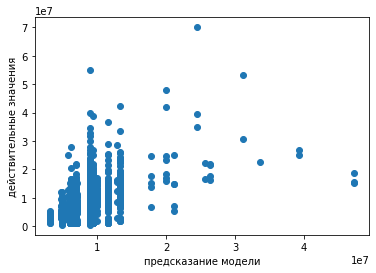

In [ ]:
X_train_2 = X_train_1.fillna(X_train_1.median())
X_test_2 = X_test_1.fillna(X_test_1.median())
print('для проверки: количество Nan-значений в X_train =',X_train_2.isna().sum().sum(),'в X_test =',X_test_2.isna().sum().sum())

clf = DecisionTreeRegressor(max_depth=5, random_state=42)
clf.fit(X_train_2, y_train)

y_pred = clf.predict(X_test_2)
plt.scatter(y_pred, y_test)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',clf.score(X_test_2, y_test))
print('MSE =',metrics.mean_squared_error(y_pred, y_test))

В результате уменьшения количества признаков R^2 упал до 0,26. Кажется удалять признаки не стоит.

Отнормируем данные

In [ ]:
#list_column_all = X_train_1.columns.tolist()

pca = StandardScaler()
pca.fit(X_train_1)
X_train_1=pca.transform(X_train_1)
X_test_1=pca.transform(X_test_1) # применяем к test нормировку с mu и sigma из train

X_train_1 = pd.DataFrame(X_train_1) 
X_test_1 = pd.DataFrame(X_test_1)  

#X_train.hist(figsize=(16,10))
None

для проверки: количество Nan-значений в X_train = 0 в X_test = 0
R^2 = 0.25897948039535745
MSE = 14756605996857.691


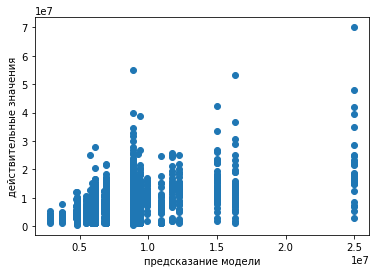

In [ ]:
X_train_1 = X_train_1.fillna(X_train_1.median())
X_test_1 = X_test_1.fillna(X_test_1.median())
print('для проверки: количество Nan-значений в X_train =',X_train_1.isna().sum().sum(),'в X_test =',X_test_1.isna().sum().sum())

clf = DecisionTreeRegressor(max_depth=5, min_samples_leaf=100, random_state=42)
clf.fit(X_train_1, y_train)

y_pred = clf.predict(X_test_1)
plt.scatter(y_pred, y_test)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',clf.score(X_test_1, y_test))
print('MSE =',metrics.mean_squared_error(y_pred, y_test))

Логарифмирование, удаление части признаков, нормализация - все это уменьшило R^2 с 0,5 до 0,25. Не понятно почему. 

Для сравнения LinearRegression на таких данных показывает R^2 = 0.25, так же плохо

LinearRegression
R^2 = 0.2561936057185743
MSE = 14812083617077.771


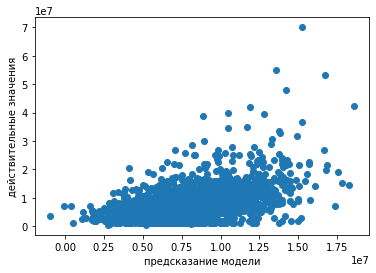

In [ ]:
from sklearn.linear_model import LinearRegression

lg = LinearRegression()
lg.fit(X_train_1, y_train)
y_pred = lg.predict(X_test_1)
print('LinearRegression')
plt.scatter(y_pred, y_test)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',lg.score(X_test_1, y_test))
print('MSE =',metrics.mean_squared_error(y_pred, y_test))

 Для эксперимента попробуем только убрать признаки VarianceThreshold и снова  обучить DecisionTreeRegressor

было =  (16000, 291) стало =  (16000, 253)
для проверки: количество Nan-значений в X_train = 0 в X_test = 0
R^2 = 0.5718423501524272
MSE = 8526287162347.568


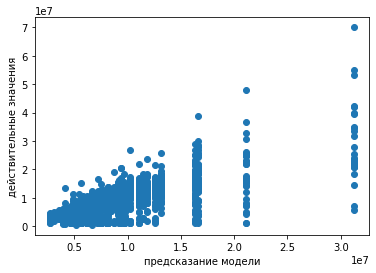

In [ ]:
df_5 = df_1.copy(deep=True)
list_column_all = df_5.columns.tolist()

# добавляем признаки
month_year = (df_5.timestamp.dt.month + df_5.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_5["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df_5.timestamp.dt.isocalendar().week + df_5.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_5["week_year_cnt"] = week_year.map(week_year_cnt_map)
df_5['floor_max_floor'] = np.minimum(1, df_5['floor'] / df_5['max_floor'])
df_5['kitch_sq_full_sq'] = np.minimum(1, df_5['kitch_sq'] / df_5['full_sq'])

# делим на train и test
df_6 = df_5.copy(deep=True)
y = df_6['price']
X = df_6.drop(columns=['price','timestamp'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

# убираем часть признаков
vth = VarianceThreshold(.9).fit(X_train)
X_train_1 = vth.transform(X_train)
X_test_1 = vth.transform(X_test)
print('было = ', X_train.shape,'стало = ', X_train_1.shape)
X_train_1 = pd.DataFrame(X_train_1)
X_test_1 = pd.DataFrame(X_test_1)

# заменяем Nan
X_train_1 = X_train_1.fillna(X_train_1.median())
X_test_1 = X_test_1.fillna(X_test_1.median())
print('для проверки: количество Nan-значений в X_train =',X_train_1.isna().sum().sum(),'в X_test =',X_test_1.isna().sum().sum())

clf = DecisionTreeRegressor(max_depth=8, min_samples_leaf=120, random_state=42)
clf.fit(X_train_1, y_train)

y_pred = clf.predict(X_test_1)
plt.scatter(y_pred, y_test)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',clf.score(X_test_1, y_test))
print('MSE =',metrics.mean_squared_error(y_pred, y_test))

Получили незначительный выйгрыш R^2 = 0,57. Это так же мало как и Baseline с R^2 = 0,55. Дальше будем рассматривать данные, с меньшим количеством признаков = 253

### Model Selection (3 балла)

Посмотрите, какого качества можно добиться если использовать разные модели:
* `DecisionTreeRegressor` из `sklearn`
* `RandomForestRegressor` из `sklearn`
* `CatBoostRegressor`

Также вы можете попробовать линейные модели, другие бустинги (`LigthGBM` и `XGBoost`).

Почти все библиотеки поддерживают удобный способ подбора гиперпараметров: посмотрите как это делать в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или в [catboost](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html).

Проверяйте качество каждой модели на тестовой выборке и выберите наилучшую.

In [ ]:
%%time
gscv_tree = HalvingGridSearchCV(DecisionTreeRegressor(),
                                [{'max_depth':range(2, 12, 2), #глубина                        
                                  'min_samples_leaf':range(10, 51, 5)} # число объектов в листе
                                 ], scoring = 'r2', cv = 5
                                )
gscv_tree.fit(X_train_1, y_train)
print('R^2 =',gscv_tree.best_score_ ,'при параметрах ',gscv_tree.best_estimator_)

R^2 = 0.5867049986224214 при параметрах  DecisionTreeRegressor(max_depth=8, min_samples_leaf=10)
CPU times: user 34.8 s, sys: 96.6 ms, total: 34.9 s
Wall time: 35.4 s


In [ ]:
%%time
gscv_forest = HalvingGridSearchCV(RandomForestRegressor(),
                                  [{'max_depth':range(2, 12, 2), # глубина
                                    'max_features':['sqrt','log2'],
                                    'n_estimators':range(10, 101, 10), # число деревьев
                                    'min_samples_leaf':range(10, 51, 10)} # число объектов в листе
                                   ], scoring = 'r2', cv = 5
                                  )
gscv_forest.fit(X_train_1, y_train)
print('R^2 =',gscv_forest.best_score_ ,'при параметрах ',gscv_forest.best_estimator_)

R^2 = 0.5499855280059422 при параметрах  RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                      n_estimators=40)
CPU times: user 8min 22s, sys: 7.69 s, total: 8min 29s
Wall time: 8min 30s


In [ ]:
%%time
cat = CatBoostRegressor()        
gscv_cat = cat.grid_search({#'learning_rate': [0.03, 0.1],
                            'depth': range(2, 12, 2), # глубина
                            'iterations':range(10, 101, 10), # число деревьев
                            'min_data_in_leaf':range(10, 51, 10)}, # число объектов в листе
                           X=X_train_1, y=y_train, verbose=False,  plot=False)
gscv_cat['params']
None

Выходные данные были обрезаны до нескольких последних строк (5000).

0:	learn: 8354180.4926986	test: 8182129.9593014	best: 8182129.9593014 (0)	total: 66.8ms	remaining: 1.94s
1:	learn: 8154324.7538069	test: 7982330.7383374	best: 7982330.7383374 (1)	total: 126ms	remaining: 1.76s
2:	learn: 7962931.7037868	test: 7791557.7702363	best: 7791557.7702363 (2)	total: 182ms	remaining: 1.64s
3:	learn: 7778204.5482263	test: 7604332.1891499	best: 7604332.1891499 (3)	total: 246ms	remaining: 1.6s
4:	learn: 7590715.6504634	test: 7415079.7858662	best: 7415079.7858662 (4)	total: 301ms	remaining: 1.5s
5:	learn: 7414291.6728304	test: 7240051.8656142	best: 7240051.8656142 (5)	total: 373ms	remaining: 1.49s
6:	learn: 7237917.0646967	test: 7063722.4461761	best: 7063722.4461761 (6)	total: 426ms	remaining: 1.4s
7:	learn: 7069172.2041515	test: 6892544.2225897	best: 6892544.2225897 (7)	total: 494ms	remaining: 1.36s
8:	learn: 6914807.6477180	test: 6738583.7236288	best: 6738583.7236288 (8)	total: 547ms	remaining: 1.2

In [44]:
gscv_cat['params']

{'depth': 8, 'iterations': 100, 'min_data_in_leaf': 10}

In [45]:
%%time
gscv_LGBM = HalvingGridSearchCV(LGBMRegressor(),
                                  [{'max_depth':range(2, 12, 2), # глубина
                                    #'max_features':['sqrt','log2'],
                                    'n_estimators':range(10, 101, 10), # число деревьев
                                    'num_leaves':range(10, 51, 10)} # число объектов в листе
                                   ], scoring = 'r2', cv = 5
                                  )
gscv_LGBM.fit(X_train_1, y_train)
print('R^2 =',gscv_LGBM.best_score_ ,'при параметрах ',gscv_LGBM.best_estimator_)

R^2 = 0.6538780114084402 при параметрах  LGBMRegressor(max_depth=4, n_estimators=40, num_leaves=10)
CPU times: user 2min 4s, sys: 1.31 s, total: 2min 5s
Wall time: 2min 29s


In [46]:
%%time
gscv_XGB = HalvingGridSearchCV(XGBRegressor(objective ='reg:squarederror'),
                                  [{'max_depth':range(2, 12, 2), # глубина
                                    'n_estimators':range(10, 101, 10), # число деревьев
                                    'max_leaves':range(10, 101, 10)} # число объектов в листе
                                   ], scoring = 'r2', cv = 5
                                  )
gscv_XGB.fit(X_train_1, y_train)
print('R^2 =',gscv_XGB.best_score_ ,'при параметрах ',gscv_XGB.best_estimator_)

R^2 = 0.6725142017898709 при параметрах  XGBRegressor(max_depth=4, max_leaves=60, n_estimators=70,
             objective='reg:squarederror')
CPU times: user 15min 48s, sys: 4.08 s, total: 15min 53s
Wall time: 16min 9s


Посмотрим какая из моделей дает большее значение R^2 ( зависимость между переменными). Запишем полученные параметры в estimator, чтобы еще раз не просчитывать GridSearchCV.

In [47]:
est_tree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=10)
est_forest = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=10, n_estimators=40)
est_cat = CatBoostRegressor(depth=8, iterations=100, min_data_in_leaf=10)
est_lg = LinearRegression()
est_LGBM = LGBMRegressor(max_depth=4, n_estimators=40, num_leaves=10)
est_XGB = XGBRegressor(max_depth=4, max_leaves=60, n_estimators=70,
             objective='reg:squarederror')

est_tree.fit(X_train_1, y_train)
est_forest.fit(X_train_1, y_train)
est_cat.fit(X_train_1, y_train, verbose = False, plot=False)
est_lg.fit(X_train_1, y_train)
est_LGBM.fit(X_train_1, y_train)
est_XGB.fit(X_train_1, y_train)

y_pred_tree = est_tree.predict(X_test_1)
y_pred_forest = est_forest.predict(X_test_1)
y_pred_cat = est_cat.predict(X_test_1)
y_pred_lg = est_lg.predict(X_test_1)
y_pred_LGBM = est_LGBM.predict(X_test_1)
y_pred_XGB = est_XGB.predict(X_test_1)

pd.DataFrame({'method':['DecisionTree','RandomForest','CatBoost','Linear','LGBM','XGB'],
              'R^2':[metrics.r2_score(y_test,y_pred_tree),
                     metrics.r2_score(y_test,y_pred_forest),
                     metrics.r2_score(y_test,y_pred_cat),
                     metrics.r2_score(y_test,y_pred_lg),
                     metrics.r2_score(y_test,y_pred_LGBM),
                     metrics.r2_score(y_test,y_pred_XGB)],
              'MSE':[metrics.mean_squared_error(y_test,y_pred_tree),
                     metrics.mean_squared_error(y_test,y_pred_forest),
                     metrics.mean_squared_error(y_test,y_pred_cat),
                     metrics.mean_squared_error(y_test,y_pred_lg),
                     metrics.mean_squared_error(y_test,y_pred_LGBM),
                     metrics.mean_squared_error(y_test,y_pred_XGB)]
              })

,method,R^2,MSE
0,DecisionTree,0.545347,9.053918e+12
1,RandomForest,0.570506,8.552895e+12
2,CatBoost,0.614851,7.669821e+12
3,Linear,0.459663,1.076022e+13
4,LGBM,0.620751,7.552330e+12
5,XGB,0.628630,7.395421e+12


Большее значение R^2 получилось у XGBRegressor. Визуально, на кросс-плоте вроде и правда точки близки к биссектрисе. Значит выбираем эту модель как лучшую. 

R^2 = 0.6286301205089766
MSE = 7395421376014.514


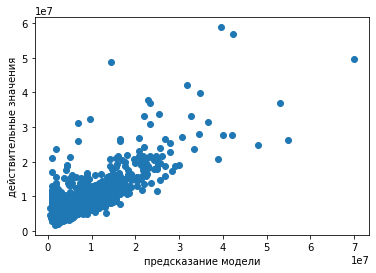

In [93]:
plt.scatter(y_test, y_pred_XGB)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',metrics.r2_score(y_test,y_pred_XGB))
print('MSE =',metrics.mean_squared_error(y_pred_XGB, y_test))

### Ensemble v.1 (3 балла)

Ансамбли иногда оказываются лучше чем одна большая модель.

В колонке `product_type` содержится информация о том, каким является объявление: `Investment` (продажа квартиры как инвестиции) или `OwnerOccupier` (продажа квартиры для жилья). Логично предположить, что если сделать по модели на каждый из этих типов, то качество будет выше.

Обучите свои лучшие модели на отдельно на `Investment` и `OwnerOccupier` (т.е. у вас будет `model_invest`, обученная на `(invest_train_X, invest_train_Y)` и `model_owner`, обученная на `(owner_train_X, owner_train_Y)`) и проверьте качество на отложенной выборке (т.е. на исходном `test_split`).

Разделим на train и test отдельно для Investment и OwnerOccupier.

In [52]:
df_7 = df_1.copy(deep=True)
list_column_all = df_7.columns.tolist()

# добавляем признаки
month_year = (df_7.timestamp.dt.month + df_7.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_7["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df_7.timestamp.dt.isocalendar().week + df_7.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_7["week_year_cnt"] = week_year.map(week_year_cnt_map)
df_7['floor_max_floor'] = np.minimum(1, df_7['floor'] / df_7['max_floor'])
df_7['kitch_sq_full_sq'] = np.minimum(1, df_7['kitch_sq'] / df_7['full_sq'])

# делим на Investment и OwnerOccupier
df_7_invest = df_7 [df_7 ['product_type']==0]
df_7_owner = df_7 [df_7 ['product_type']==1]

# делим на train и test
df_8_invest = df_7_invest.copy(deep=True)
y_invest = df_8_invest['price']
X_invest = df_8_invest.drop(columns=['price','timestamp'])
X_invest_train, X_invest_test, y_invest_train, y_invest_test = train_test_split(X_invest, y_invest, test_size=0.2,  random_state=42)
df_8_owner = df_7_owner.copy(deep=True)
y_owner = df_8_owner['price']
X_owner = df_8_owner.drop(columns=['price','timestamp'])
X_owner_train, X_owner_test, y_owner_train, y_owner_test = train_test_split(X_owner, y_owner, test_size=0.2,  random_state=42)

# убираем часть признаков
print('invest было = ', X_invest_train.shape)
X_invest_train = vth.transform(X_invest_train)
X_invest_test = vth.transform(X_invest_test)
print('       стало = ', X_invest_train.shape)
X_invest_train = pd.DataFrame(X_invest_train)
X_invest_test = pd.DataFrame(X_invest_test)

print('owner было = ', X_owner_train.shape)
X_owner_train = vth.transform(X_owner_train)
X_owner_test = vth.transform(X_owner_test)
print('       стало = ', X_owner_train.shape)
X_owner_train = pd.DataFrame(X_owner_train)
X_owner_test = pd.DataFrame(X_owner_test)

# заменяем Nan
X_invest_train = X_invest_train.fillna(X_invest_train.median())
X_invest_test = X_invest_test.fillna(X_invest_test.median())
print('для проверки invest: количество Nan-значений в X_train =',X_invest_train.isna().sum().sum(),'в X_test =',X_invest_test.isna().sum().sum())
X_owner_train = X_owner_train.fillna(X_owner_train.median())
X_owner_test = X_owner_test.fillna(X_owner_test.median())
print('для проверки owner: количество Nan-значений в X_train =',X_owner_train.isna().sum().sum(),'в X_test =',X_owner_test.isna().sum().sum())

invest было =  (10272, 291)
       стало =  (10272, 253)
owner было =  (5728, 291)
       стало =  (5728, 253)
для проверки invest: количество Nan-значений в X_train = 0 в X_test = 0
для проверки owner: количество Nan-значений в X_train = 0 в X_test = 0


Обучили отдельно две модели для Investment и OwnerOccupier.

In [97]:
model_invest = XGBRegressor(max_depth=4, max_leaves=60, n_estimators=70,
             objective='reg:squarederror')
model_invest.fit(X_invest_train, y_invest_train)
model_owner = XGBRegressor(max_depth=4, max_leaves=60, n_estimators=70,
             objective='reg:squarederror')
model_owner.fit(X_owner_train, y_owner_train)

XGBRegressor(max_depth=4, max_leaves=60, n_estimators=70,
             objective='reg:squarederror')

Согласно идее Стекинга: для каждой из них получим предсказания для X_test_1 и найдем среднее между ними. Это значение и будем сравнивать с y_test.

R^2 = 0.6680930213920959
MSE = 6609561248772.78


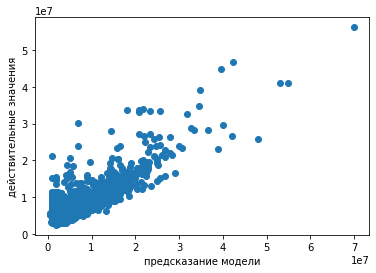

In [104]:
y_pred_XGB_invest = model_invest.predict(X_test_1)
y_pred_XGB_owner = model_owner.predict(X_test_1)
y_pred_XGB_invest_owner = (y_pred_XGB_invest + y_pred_XGB_owner )*0.5

plt.scatter(y_test, y_pred_XGB_invest_owner)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',metrics.r2_score(y_test,y_pred_XGB_invest_owner))
print('MSE =',metrics.mean_squared_error(y_pred_XGB_invest_owner, y_test))

А это и правда помогло увеличить R^2. Для сравнения еще попробуем аналогичные действия сделать для LGBMRegressor, потому что у него тоже R^2 получился 0,62. И для CatBoostRegressor, т.к. он третий по значению R^2.

R^2 = 0.6364710294794416
MSE = 7239278325622.182


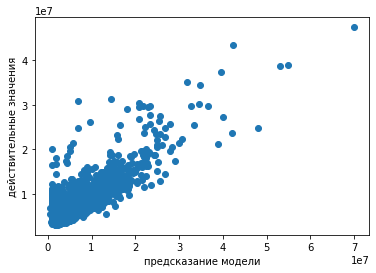

In [134]:
model_invest_LGBM = LGBMRegressor(max_depth=4, n_estimators=40, num_leaves=10)
model_invest_LGBM.fit(X_invest_train, y_invest_train)
model_owner_LGBM = LGBMRegressor(max_depth=4, n_estimators=40, num_leaves=10)
model_owner_LGBM.fit(X_owner_train, y_owner_train)

y_pred_LGBM_invest = model_invest_LGBM.predict(X_test_1)
y_pred_LGBM_owner = model_owner_LGBM.predict(X_test_1)
y_pred_LGBM_invest_owner = (y_pred_LGBM_invest + y_pred_LGBM_owner )*0.5

plt.scatter(y_test, y_pred_LGBM_invest_owner)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',metrics.r2_score(y_test,y_pred_LGBM_invest_owner))
print('MSE =',metrics.mean_squared_error(y_pred_LGBM_invest_owner, y_test))

Learning rate set to 0.38461
0:	learn: 4103978.2737457	total: 196ms	remaining: 19.4s
1:	learn: 3614267.2263219	total: 353ms	remaining: 17.3s
2:	learn: 3351371.6567185	total: 527ms	remaining: 17s
3:	learn: 3171412.0860344	total: 679ms	remaining: 16.3s
4:	learn: 3070275.9547963	total: 829ms	remaining: 15.8s
5:	learn: 2989170.0805076	total: 990ms	remaining: 15.5s
6:	learn: 2925568.4408184	total: 1.14s	remaining: 15.1s
7:	learn: 2857637.4132282	total: 1.3s	remaining: 14.9s
8:	learn: 2821001.1711623	total: 1.48s	remaining: 14.9s
9:	learn: 2772448.2679482	total: 1.63s	remaining: 14.7s
10:	learn: 2728554.1357505	total: 1.79s	remaining: 14.5s
11:	learn: 2703952.4847196	total: 1.94s	remaining: 14.2s
12:	learn: 2671162.8896473	total: 2.09s	remaining: 14s
13:	learn: 2650350.1611661	total: 2.25s	remaining: 13.8s
14:	learn: 2615345.7473904	total: 2.42s	remaining: 13.7s
15:	learn: 2603101.2631369	total: 2.59s	remaining: 13.6s
16:	learn: 2583510.1564836	total: 2.74s	remaining: 13.4s
17:	learn: 256686

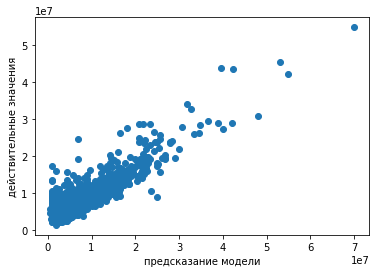

In [154]:
model_invest_cat = CatBoostRegressor(depth=8, iterations=100, min_data_in_leaf=10)
model_invest_cat.fit(X_invest_train, y_invest_train)
model_owner_cat = CatBoostRegressor(depth=8, iterations=100, min_data_in_leaf=10)
model_owner_cat.fit(X_owner_train, y_owner_train)

y_pred_cat_invest = model_invest_cat.predict(X_test_1)
y_pred_cat_owner = model_owner_cat.predict(X_test_1)
y_pred_cat_invest_owner = (y_pred_cat_invest + y_pred_cat_owner )*0.5

plt.scatter(y_test, y_pred_cat_invest_owner)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',metrics.r2_score(y_test,y_pred_cat_invest_owner))
print('MSE =',metrics.mean_squared_error(y_pred_cat_invest_owner, y_test))

Для LGBMRegressor получился R^2 = 0.636. Для XGBRegressor R^2 = 0.668. Для CatBoostRegressor R^2 = 0.742, поэтому выбираем CatBoostRegressor для данной задачи.

### (*) Ensemble v.2 (дополнительно, 2 балла)

Попробуйте сделать для `Investment` более сложную модель: обучите `CatBoostRegressor` и `HuberRegressor` из `sklearn`, а затем сложите их предсказания с весами `w_1` и `w_2` (выберите веса сами; сумма весов равняется 1).

Посмотрим какой R^2 покажет HuberRegressor на X_invest_train. С параметрами по умолчанию значение отрицательное, значит эта модель совершенно не описывает наши данные. 

In [124]:
est_Huber_invest = linear_model.HuberRegressor()
est_Huber_invest.fit(X_invest_train, y_invest_train)
print('R^2 =',metrics.r2_score(y_invest_test,est_Huber_invest.predict(X_invest_test)))

R^2 = -0.046376874331151674


In [128]:
%%time
gscv_Huber_invest = HalvingGridSearchCV(linear_model.HuberRegressor(),
                                 [{'epsilon':np.arange(1, 5, 0.1), # количество выборок-выбросов
                                   'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]} # параметр регуляризации
                                  ], scoring = 'r2', cv = 5
                                 )
gscv_Huber_invest.fit(X_invest_train, y_invest_train)
print('R^2 =',gscv_Huber_invest.best_score_ ,'при параметрах ',gscv_Huber_invest.best_estimator_)

R^2 = -0.051078115429286086 при параметрах  HuberRegressor(alpha=0.1, epsilon=3.300000000000002)
CPU times: user 5min 25s, sys: 1min 57s, total: 7min 22s
Wall time: 5min 8s


После перебора параметров лучшее значение R^2 тоже отрицательное. Тогда возьмем HuberRegressor() с параметрами по умолчанию. Ее предсказание зададим с очень маленьким весом по сравнению с предсказанием CatBoostRegressor.

Подберем параметры для CatBoostRegressor.

In [140]:
%%time
cat_invest = CatBoostRegressor()        
gscv_cat_invest = cat_invest.grid_search({#'learning_rate': [0.03, 0.1],
                            'depth': range(2, 12, 2), # глубина
                            'iterations':range(10, 101, 10), # число деревьев
                            'min_data_in_leaf':range(10, 51, 10)}, # число объектов в листе
                           X=X_invest_train, y=y_invest_train, verbose=False,  plot=False)
None

Выходные данные были обрезаны до нескольких последних строк (5000).

0:	learn: 8805282.5917029	test: 8444258.1026788	best: 8444258.1026788 (0)	total: 63.8ms	remaining: 1.85s
1:	learn: 8605776.1974243	test: 8247859.5922585	best: 8247859.5922585 (1)	total: 115ms	remaining: 1.6s
2:	learn: 8409872.8676011	test: 8057071.4973598	best: 8057071.4973598 (2)	total: 183ms	remaining: 1.64s
3:	learn: 8211752.4134422	test: 7860080.2978428	best: 7860080.2978428 (3)	total: 237ms	remaining: 1.54s
4:	learn: 8018895.5817037	test: 7663944.2395687	best: 7663944.2395687 (4)	total: 290ms	remaining: 1.45s
5:	learn: 7846309.4087111	test: 7490309.8417770	best: 7490309.8417770 (5)	total: 345ms	remaining: 1.38s
6:	learn: 7673275.3126737	test: 7315833.2143994	best: 7315833.2143994 (6)	total: 410ms	remaining: 1.35s
7:	learn: 7500049.1714764	test: 7142009.3686926	best: 7142009.3686926 (7)	total: 483ms	remaining: 1.33s
8:	learn: 7333209.5393525	test: 6973945.3887542	best: 6973945.3887542 (8)	total: 541ms	remaining: 1

In [141]:
gscv_cat_invest['params']

{'depth': 8, 'iterations': 100, 'min_data_in_leaf': 10}

Параметры CatBoostRegressor для данных Investment получились такие же как и для всего набора данных. Теперь подберем веса для предсказания Investment по CatBoostRegressor и HuberRegressor

In [143]:
gscv_cat_invest = CatBoostRegressor(depth=8, iterations=100, min_data_in_leaf=10, verbose=False)
gscv_cat_invest.fit(X_invest_train, y_invest_train)
gscv_Huber_invest = linear_model.HuberRegressor()
gscv_Huber_invest.fit(X_invest_train, y_invest_train)

# часть Investment
model_invest_cat = CatBoostRegressor(depth=8, iterations=100, min_data_in_leaf=10, verbose=False)
model_invest_cat.fit(X_invest_train, y_invest_train)
model_invest_huber = linear_model.HuberRegressor()
model_invest_huber.fit(X_invest_train, y_invest_train)

# часть OwnerOccupier
model_owner_cat = CatBoostRegressor(depth=8, iterations=100, min_data_in_leaf=10, verbose=False)
model_owner_cat.fit(X_owner_train, y_owner_train)

y_pred_cat_invest = model_invest_cat.predict(X_test_1)
y_pred_huber_invest = model_invest_huber.predict(X_test_1)
y_pred_cat_owner = model_owner_cat.predict(X_test_1)

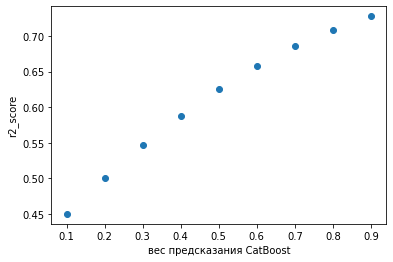

In [150]:
R_2 = []
weight = np.arange(0.1,1,0.1)
for i in weight:
  y_pred_invest = i * y_pred_cat_invest + (1-i) * y_pred_huber_invest
  y_pred_all = (y_pred_invest + y_pred_cat_owner )*0.5
  R_2.append(metrics.r2_score(y_test,y_pred_all))
plt.scatter(weight,R_2)
plt.xlabel('вес предсказания CatBoost')
plt.ylabel('r2_score')
None

Модель HuberRegressor для Investment у нас получилась плохая, поэтому чем меньше вес предсказаний HuberRegressor и больше CatBoostRegressor, тем выше R^2. Думаю для данной задачи не стоит использовать модель HuberRegressor, либо я не пока не понимаю как ее настроить для увеличения score.

Если поставить вес = 0,05 для предсказания HuberRegressor получим R^2 = 0.736. Это ниже, чем без HuberRegressor R^2 = 0.742. Значит для данной задачи лучше выбрать модель CatBoostRegressor.

R^2 = 0.7355198409311472
MSE = 5266830537226.675


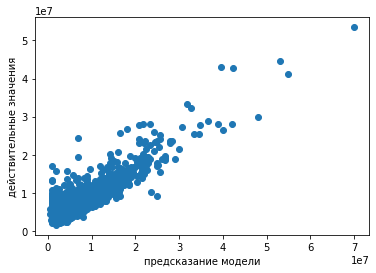

In [151]:
y_pred_invest = 0.95 * y_pred_cat_invest + 0.05 * y_pred_huber_invest
y_pred_all = (y_pred_invest + y_pred_cat_owner )*0.5

plt.scatter(y_test, y_pred_all)
plt.xlabel('предсказание модели')
plt.ylabel('действительные значения')
print('R^2 =',metrics.r2_score(y_test,y_pred_all))
print('MSE =',metrics.mean_squared_error(y_pred_all, y_test))